In [221]:
library(reshape2)
library(dplyr)
library(xtable)

## Plotting
library(pROC)
library(ggplot2)
library(cowplot)
library(rgl)
library(RColorBrewer)
library(pheatmap)
library(UpSetR)
library(VennDiagram)
library(Rtsne)
library(igraph)
# library(dendextend)
library(repr)
options(repr.plot.width=8, repr.plot.height=4)

library(limma)
library(sva)

## Custom
source("../functions.R")

In [3]:
# FUNCTIONS ---------------------------------------------------------------
plot_mean <- function(df, batch_vec1) {
  # Melt dataframe
  melt_df <- melt(df, variable.name = "ID")
  print(head(melt_df))
  # Trimmed mean probe intensities for each chip
  mean_tibble <- melt_df %>% group_by(ID) %>%
    summarise(mean = mean(value))
  mean_batch_tibble <- cbind(mean_tibble,
                             batch_vec1 = batch_vec1[mean_tibble$ID])
  
  mean_scatter <- ggplot(mean_batch_tibble, aes(x = ID, y = mean)) +
    geom_point(aes(col = factor(batch_vec1)),
               show.legend = F, size = 3) +
    facet_wrap(factor(batch_vec1), scales = "free_x") +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank())
  return(mean_scatter)
}

# Selecting drug responsive genes between D0 and D8
# using paired t-test and logfc
selectFeatures <- function(df1, metadata_df,
                           alpha = 0.05, logfc_threshold = 1) {
  # Subset df according to D0 and D8
  class_info <- metadata_df[colnames(df1), "class_info"]
  df_d0 <- df1[,class_info == "D0"]
  df_d8 <- df1[,class_info == "D8"]
  print(head(colnames(df_d0)))
  print(head(colnames(df_d8)))
  stopifnot(ncol(df_d0) == ncol(df_d8))
  
  # Identify drug responsive probesets
  ttest_pvalue <- calc_ttest(cbind(df_d0, df_d8), ncol(df_d0), is_paired = T)
  log_fc <- rowMeans(df_d8) - rowMeans(df_d0)
  ttest_probesets <- names(ttest_pvalue)[ttest_pvalue <= alpha]
  fc_probesets <- names(log_fc)[log_fc > logfc_threshold]
  intersect_probesets <- intersect(ttest_probesets, fc_probesets)
  print(paste("T-test:", length(ttest_probesets)))
  print(paste("Log fold change:", length(fc_probesets)))
  print(paste("Intersection:", length(intersect_probesets)))
  return(intersect_probesets)
}

# 3D PCA plot
plotPCA3D <- function(df, colour, pch, pc_labels = NULL,
                      ratio_list = list(2,1,1)) {
  if (is.null(pc_labels)) {
    print("PCA performed!")
    pca_obj <- prcomp(t(df), center = T, scale. = F)
    pca_df <- as.data.frame(pca_obj$x[,1:3])
    eigenvalues <- (pca_obj$sdev)^2
    var_pc <- eigenvalues[1:3]/sum(eigenvalues)
    print(var_pc)
    pc_labels <- sprintf("PC%d (%.2f%%)", 1:3, var_pc*100)
  } else {
    print("No PCA performed!")
    pca_df <- as.data.frame(df)
  }
  
  # RGL plot parameters
  rgl.open()
  rgl.bg(color="white")
  rgl.viewpoint(zoom = 0.8)
  # rgl.viewpoint(theta = 110, phi = 5, zoom = 0.8)
  par3d(windowRect = c(50, 20, 500, 500))
  with(pca_df, pch3d(PC1, PC2, PC3, bg = colour,
                     pch = pch, cex = 0.5, lwd = 1.5))
  box3d(col = "black")
  title3d(xlab = pc_labels[1], ylab = pc_labels[2],
          zlab = pc_labels[3], col = "black")
  # Plot aspect ratios of axis according to variance
  do.call(aspect3d, ratio_list)
}

# Plot PCA before selecting features
# Batch information of all the timepoints
plotPCA3DYeoh <- function(df1, metadata_df) {
  batch_info <- metadata_df[colnames(df1), "batch_info"]
  generate_colour <- colorRampPalette(c("lightblue", "darkblue"))
  batch_palette <- generate_colour(10)
  # batch_palette <- brewer.pal(10, "Set3")
  batch_colour <- batch_palette[batch_info]
  # Shape of all timepoints
  class_info <- metadata_df[colnames(df1), "class_info"]
  print(levels(class_info))
  levels(class_info) <- 21:23
  timepoint_shape <- as.numeric(as.character(class_info))
  plotPCA3D(df1, batch_colour, timepoint_shape)
}

# Plot PCA before selecting features
# Batch information of all the timepoints
plotPCA3DYeoh1 <- function(df1, metadata_df) {
  batch_info <- metadata_df[colnames(df1), "batch_info"]
  batch_factor <- droplevels(as.factor(batch_info))
  print(batch_factor)
  print(levels(batch_factor))
  levels(batch_factor) <- 21:22
  pch <- as.numeric(as.character(batch_factor))
  # generate_colour <- colorRampPalette(c("lightblue", "darkblue"))
  # batch_palette <- generate_colour(10)
  
  # Shape of all timepoints
  class_info <- metadata_df[colnames(df1), "subtype"]
  palette <- brewer.pal(10, "Set3")
  col <- palette[class_info]
  
  plotPCA3D(df1, col, pch)
}

plotJitterYeoh <- function(X, metadata_df, n_pc = 10) {
  pca_obj <- prcomp(t(X))
  X_pca <- data.frame(pca_obj$x)
  batch <- as.factor(metadata_df[rownames(X_pca),"batch_info"])
  class <- as.factor(metadata_df[rownames(X_pca),"class_info"])
  X_meta <- cbind(batch, class, X_pca[,1:n_pc])
  X_long <- melt(X_meta, id = c("batch", "class"), variable.name="PC")
  
  ax_batch <- ggplot(X_long, aes(x=PC, y=value)) +
    # geom_boxplot(aes(fill=batch), alpha=0.3, outlier.shape=NA) +
    geom_point(aes(colour=batch), position=position_jitterdodge(),
               size = 1, alpha = 1.0)
  
  ax_class <- ggplot(X_long, aes(x=PC, y=value)) +
    # geom_boxplot(aes(fill=class), alpha=0.3, outlier.shape=NA) +
    geom_point(aes(colour=class), position=position_jitterdodge(),
               size = 1, alpha = 1.0)
  
  fig <- plot_grid(ax_batch, ax_class, nrow = 2)
  return(fig)  
}

plotFeatures <- function(results, metadata_df) {
  y <- as.factor(metadata_df[rownames(results),"label"])
  subset_features1 <- c("erm1", "angle_d0d8_normal", "l2norm_d0_d8",
                        "l2norm_d0_normal", "l2norm_d8_normal", "l2norm_diff",
                        "erm1_ratio1", "erm1_ratio2", "erm1_ratio3",
                        "l2norm_ratio1", "l2norm_ratio2", "l2norm_diff_ratio")
  
  features1 <- results[, subset_features1, drop=F]
  features1_y <- data.frame(features1, label = y)
  long_features1_y <- melt(features1_y, id="label", variable.name = "feature")
  
  # PLOT: FEATURES
  jitter_features1 <- ggplot(long_features1_y) +
    geom_point(aes(feature, value, colour = label),
               position = position_jitterdodge(), cex = 3,
               show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3")) +
    facet_wrap(~feature, nrow = 2, ncol = 6,  scales = "free") +
    theme(axis.title.x=element_blank(),
          axis.text.x=element_text(angle = 10, vjust = 0.5))
  
  return(jitter_features1)
}

# Factor to split data
splitSubtype <- function(X, metadata_df) {
  if (!is(X, "data.frame"))
    X <- data.frame(X)
  
  subtype_factor <- as.factor(metadata_df[colnames(X), "subtype"])
  split.default(X, subtype_factor, drop = F) # Split by subtype
}

## Import data

In [4]:
## Metadata
METADATA_RPATH <- "data/GSE67684/processed/metadata/full_metadata.tsv"
metadata_df <- read.table(METADATA_RPATH, sep = "\t")
BATCH_RPATH <- "data/GSE67684/processed/metadata/metadata-batch.tsv"
LABEL_RPATH <- "data/GSE67684/processed/metadata/metadata-label_mrd_subtype.tsv"
yeoh_batch <- read.table(BATCH_RPATH, sep = "\t", header = T, row.names = 1)
yeoh_label <- read.table(LABEL_RPATH, sep = "\t", header = T, row.names = 1)

## Subset of original data
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")
# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
data <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_df))

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] D0 D0 D0 D0 D0 D0
Levels: D0 D8 N
           D0    D8     N
1053_at  TRUE  TRUE  TRUE
117_at  FALSE  TRUE  TRUE
121_at   TRUE  TRUE  TRUE
1294_at  TRUE  TRUE  TRUE
1316_at  TRUE  TRUE  TRUE
1320_at FALSE FALSE FALSE
[1] "No. of probesets removed = 6321"


### Commonly used globals

In [5]:
Y <- metadata_df[colnames(data),]
Y_annot <- Y[,c("batch_info", "label")] # heatmap annot
# Y_all <- all_metadata[colnames(data_all),]

pid_remission <- rownames(Y)[Y$label == 0]

# List subtypes
all_subtypes <- levels(metadata_df$subtype)
subtypes <- setdiff(all_subtypes, c("Hypodiploid", "Normal"))

## Relapse prediction

Factors of variation: Timepoint, batch, subtype, remission

### Batch genes

Constant: Timepoint, subtype , remission

In [6]:
# Prediction (Batch genes) -------------------------------------------------------
## Batch genes
# Only D0 samples
pid_d0 <- rownames(metadata_df)[metadata_df$class_info == "D0"]
pid_telaml1 <- rownames(metadata_df)[metadata_df$subtype == "TEL-AML1"]
pid_remission <- rownames(metadata_df)[metadata_df$label == 0]

# Recursive intersect
pid_idx <- Reduce(intersect, list(pid_d0, pid_telaml1, pid_remission, colnames(data)))

d0_telaml1 <- data[,pid_idx]
d0_batch <- metadata_df[colnames(d0_telaml1), "batch_info"]
d0_telaml1_t <- t(d0_telaml1)

#' @param X matrix with samples as rows and features as columns
calcBatchANOVA <- function(X, batch, method = "welch") {
  .featureANOVA <- function(vec, d0_batch, method) {
    X <- data.frame(gene = vec,
                    batch = as.factor(d0_batch))
    
    if (method == "welch") return(oneway.test(gene~batch, X)$p.value)
    else if (method == "aov") return(unname(unlist(summary(aov(gene~batch, data = X)))[9]))
    else if (method == "kruskal") return(kruskal.test(gene~batch, X)$p.value)
    else stop("option not available for argument: method")
  }
  
  pvalue <- sapply(data.frame(X), .featureANOVA, batch, method)
  names(pvalue) <- substring(names(pvalue), 2)
  n_nan <- sum(sapply(pvalue, is.na))
  print(c("No. of NaNs =", n_nan))
  return(pvalue)
}

aov_pvalue <- calcBatchANOVA(d0_telaml1_t, d0_batch, method = "aov")
# welch_pvalue <- calcBatchANOVA(d0_telaml1_t, d0_batch, method = "welch")
# kruskal_pvalue <- calcBatchANOVA(d0_telaml1_t, d0_batch, method = "kruskal")

# Selecting by pvalue threshold
batch_genes <- names(aov_pvalue)[aov_pvalue < 0.05 & !is.na(aov_pvalue)]
# welch_genes <- names(welch_pvalue)[welch_pvalue < 0.05 & !is.na(welch_pvalue)]
# kruskal_genes <- names(kruskal_pvalue)[kruskal_pvalue < 0.05 & !is.na(kruskal_pvalue)]
length(batch_genes)

[1] "No. of NaNs =" "16"           


[1] 2565

### Drug genes

Constant: Subtype, remission

In [7]:
# Prediction (Drug genes) --------------------------------------------
## Drug responsive genes
#' @param X_subtype df of patients from a specific subtype (D0 followed by D8)
getLocalGenes <- function(X_subtype, pid_remission,
                          alpha = 0.05, EXPR = 6, N = 50, LOGFC = 1) {
  pid_idx <- intersect(pid_remission, colnames(X_subtype))
  X_subtype_remission <- X_subtype[,pid_idx, drop = F]
  n_pairs <- ncol(X_subtype_remission)/2
  
  # P-value
  pvalue <- calc_ttest(X_subtype_remission, n_pairs, is_paired = T) # nan values!

  # # Q-value
  # calc_qvalue <- function(p) length(p)*p/rank(p)
  # qvalue <- calc_qvalue(pvalue) # FDR threshold
  # hist(qvalue, breaks =20)
  
  # Median paired log-FC
  paired_logfc <- X_subtype_remission[,-(1:n_pairs)] -
    X_subtype_remission[,1:n_pairs] # D8 - D0
  median_logfc <- apply(paired_logfc, 1, median)
  print(sprintf("No. of NaN values in log-fc = %d",
                 sum(is.na(median_logfc))))
  median_logfc1 <- median_logfc[!is.na(median_logfc)]
  
  d0_mu <- rowMeans(X_subtype_remission[,1:n_pairs])
  d8_mu <- rowMeans(X_subtype_remission[,-(1:n_pairs)])
  selected_median_logfc <- median_logfc1[d0_mu > EXPR | d8_mu > EXPR]
  print(sprintf("No. of probesets excluded by expr threshold = %d",
                length(median_logfc1) - length(selected_median_logfc)))
  # feat_top_median_logfc <- names(head(sort(selected_median_logfc), N))
  
  # # Custom t-statistic
  # deviation_median <- sweep(paired_logfc, 1, median_logfc, "-")
  # median_abs_dev <- apply(abs(deviation_median), 1, median)
  # test_stat <- median_logfc/(median_abs_dev/n_pairs^0.5)
  # pvalue <- pt(abs(test_stat)*-1, n_pairs-1)
  # hist(pvalue, breaks = 30)
  # feat_selected_p <- names(head(sort(pvalue), N))

  feat_p <- names(pvalue)[pvalue < alpha & !is.na(pvalue)]
  # At least one of the means have to be > EXPR
  feat_log2fc <- names(selected_median_logfc)[abs(selected_median_logfc) > LOGFC]
  print(sprintf("No. of features (p-value) = %d", length(feat_p)))
  print(sprintf("No. of features (log2-fc) = %d", length(feat_log2fc)))
  feat <- intersect(feat_p, feat_log2fc)
  return(feat)
}

In [8]:
#' @param response_df dataframe with samples x features
#' @param normal_df dataframe with samples x features
# D0 centroid used to define D0-Normal vector
calcERM <- function(response_df, normal_df) {
  # Split response df into D0 and D8 df
  n <- nrow(response_df)/2
  d0_df <- response_df[1:n,]
  d8_df <- response_df[-(1:n),]
  stopifnot(substring(rownames(d8_df),1,4) == substring(rownames(d0_df),1,4))
  
  # Calculate centroids
  leuk_centroid <- apply(d0_df, 2, median)
  normal_centroid <- apply(normal_df, 2, median)
  
  # Calculate leuk-normal unit vector
  leuk_normal <- normal_centroid - leuk_centroid
  unit_leuk_normal <- leuk_normal/calcL2Norm(leuk_normal)
  
  # Assume that patients from top rows match correspondingly with bottom rows
  # Calculate vector by: D8-D0
  d0_d8_hstack <- d8_df - d0_df
  # Multiplication of erm_factor is propagated through every column
  ### ERM1 ###
  erm1 <- colSums(t(d0_d8_hstack) * unit_leuk_normal)
  # Vertical stack of individual D0-Normal vectors
  d0_normal_vstack <- normal_centroid - t(d0_df)
  ### D0-Normal projection ###
  d0_normal_proj <- colSums(d0_normal_vstack * unit_leuk_normal)
  ### ERM1 Ratio ###
  ## ERM1 / projection of D0-N on L-N
  erm1_ratio1 <- erm1/d0_normal_proj
  
  d8_normal_vstack <- normal_centroid - t(d8_df)
  ### D8-Normal projection ###
  d8_normal_proj <- colSums(d8_normal_vstack * unit_leuk_normal)
  
  stopifnot(identical(names(erm1), names(erm1_ratio1)))
  
  # Calculate vstack of unit D0-Normal vectors
  l2norm_d0_normal <- apply(d0_normal_vstack, 2, calcL2Norm)
  unit_d0_normal_vstack <- sweep(d0_normal_vstack, 2, l2norm_d0_normal, "/")
  
  ### ERM2 ###
  ## Projection of D0-D8 on D0-N
  erm2 <- colSums(t(d0_d8_hstack) * unit_d0_normal_vstack)
  erm2_ratio <- erm2/l2norm_d0_normal
  
  stopifnot(identical(names(erm2), names(erm2_ratio)))
  
  ### ERM3 ###
  ## Along a chosen PC that represents timepoint
  PC <- 1
  # Be careful of direction of D0-N (may be negative)
  # If negative, a larger shift will lead to a smaller ERM3
  dir <- sign(median(normal_df[,PC]) - median(d0_df[,PC]))
  erm3 <- (d8_df[,PC] - d0_df[,PC]) * dir # direction is normalised
  # Divide by D0-Normal along PC
  erm3_ratio <- erm3/(median(normal_df[,PC]) - d0_df[,PC])
  
  stopifnot(identical(names(erm3), names(erm3_ratio)))
  
  ### l2norm ###
  l2norm_d0_d8 <- apply(d0_d8_hstack, 1, calcL2Norm)
  l2norm_d0 <- apply(d0_df, 1, calcL2Norm)
  l2norm_d8 <- apply(d8_df, 1, calcL2Norm)
  diff_l2norm <- l2norm_d8 - l2norm_d0
  
  ### Angle between D0-D8 and Leuk-Normal ###
  angle_d0d8_normal <- apply(
    d0_d8_hstack, 1, function(row_vec) calcAngleVectors(row_vec, leuk_normal)
  )
  
  ### Angle between D0-D8 and D0-Normal ###
  angle_d0d8_d0normal <- mapply(calcAngleVectors,
                                data.frame(t(d0_d8_hstack)),
                                data.frame(d0_normal_vstack))
  
  ### Angle between D0 and D8 ###
  angle_d0_d8 <- mapply(calcAngleVectors,
                        data.frame(t(d0_df)), data.frame(t(d8_df)))
  
  ### Angle between D0 and normal ###
  angle_d0_normal <- apply(
    d0_df, 1, function(row_vec) calcAngleVectors(row_vec, normal_centroid)
  )
  
  ### Angle between D8 and Normal ###
  angle_d8_normal <- apply(
    d8_df, 1, function(row_vec) calcAngleVectors(row_vec, normal_centroid)
  )
  
  ### Angle between N-D0 and N-D8 ###
  # Equivalent to angle between D0-N and D8-N
  angle_nd0_nd8 <- mapply(calcAngleVectors,
                          data.frame(d0_normal_vstack),
                          data.frame(d8_normal_vstack))
  
  ### Angle between N-centroid(D0) N-D8 ###
  # Equivalent to angle between centroid(D0)-N and D8-N
  angle_nl_nd8 <- sapply(data.frame(d8_normal_vstack),
                         function(x, y) calcAngleVectors(x, y),
                         leuk_normal)
  
  ### L2-norm between D8 and Normal ###
  l2norm_d8_normal <- apply(d8_normal_vstack, 2, calcL2Norm)
  
  ### L2-norm ratios
  l2norm_ratio1 <- l2norm_d0_d8/l2norm_d0_normal
  l2norm_ratio2 <- l2norm_d0_d8/l2norm_d8_normal
  l2norm_diff <- l2norm_d0_normal - l2norm_d8_normal
  l2norm_diff_ratio <- l2norm_diff/l2norm_d0_d8
  
  ### Ratios
  erm1_ratio2 <- erm1/abs(d8_normal_proj)
  erm1_ratio3 <- erm1/l2norm_d0_d8
  
  ### Concatenate all features ###
  features_df <- data.frame(
    erm1, erm1_ratio1, erm2, erm2_ratio, erm3, erm3_ratio,
    d0_normal_proj, d8_normal_proj, l2norm_d0_d8,
    diff_l2norm, angle_d0_d8, angle_nd0_nd8, angle_nl_nd8,
    angle_d0d8_normal, angle_d0d8_d0normal,
    angle_d0_normal, angle_d8_normal,
    l2norm_d0_normal, l2norm_d8_normal,
    l2norm_ratio1, l2norm_ratio2,
    l2norm_diff, l2norm_diff_ratio,
    erm1_ratio2, erm1_ratio3
  )
  
  rownames(features_df) <- substring(rownames(features_df), 1, 4)
  return(features_df)
}

In [129]:
sprintf("%s %f", LETTERS[1:3], rep(.5, 3))

[1] "A 0.500000" "B 0.500000" "C 0.500000"

In [10]:
#' @param Y metadata_df that has rownames corresponding to the
#' @param mrd_global vector of m MRD values where m is the
#' total number of patients being evaluated. For train/test split,
#' please supply mrd of samples that are both remission and in
#' the train set
plotPrediction <- function(results, metadata_df, yeoh_label,
                           mrd_global, idx1_train = NULL, idx1_test = NULL) {
  # Feature selection and rank
  y <- as.factor(metadata_df[rownames(results), "label"])
  features1 <- results[, c("erm1_ratio2", "l2norm_ratio2"), drop = F] # relapse: smaller
  features2 <- results[, "angle_d0d8_normal", drop = F] # relapse: bigger
  
  # MRD
  mrd <- yeoh_label[rownames(results), "d33_mrd"]
  names(mrd) <- rownames(results)
  
  #' NB: Changed from previous calculation! Previous calculations used
  #' pct of samples strictly below value. Calculated  pct locally
  #' Calculates risk of relapse using pct of samples via ranks
  #' @param X1 df of features where smaller values indicate relapse
  #' @param X2 df of features where bigger values indicate relapse
  #' @param mrd vector of  with order matching rownames of X1 and X2
  #' @return df containing pid, label, risk of relapse, and p of indv features
  calc_pct_samples <- function(X1 = NULL, X2 = NULL, mrd) {
    # TODO: Global  will be better!
    # Calculating pct samples for mrd
    n_le_mrd <- rank(mrd, na.last = T, ties.method = "max")
    pct_le_mrd <- n_le_mrd / sum(!is.na(mrd))
    pct_le_mrd[is.na(mrd)] <- NA # NAs are given ranks as well
    
    # Assumption: Either X1 or X2 will not be NULL
    if (is.null(X1)) {
      n_le <- apply(X2, 2, rank, ties.method = "max") # ranks smallest as 1
      pct_le <- n_le / nrow(X2)
      pct_all <- cbind(pct_le, mrd = pct_le_mrd)
    } else if (is.null(X2)) {
      n_ge <- apply(-X1, 2, rank, ties.method = "max") # ranks biggest as 1
      pct_ge <- n_ge / nrow(X1)
      pct_all <- cbind(pct_ge, mrd = pct_le_mrd)
    } else {
      n_le <- apply(X2, 2, rank, ties.method = "max") # ranks smallest as 1
      pct_le <- n_le / nrow(X2)
      n_ge <- apply(-X1, 2, rank, ties.method = "max") # ranks biggest as 1
      pct_ge <- n_ge / nrow(X1)
      pct_all <- cbind(pct_ge, pct_le, mrd = pct_le_mrd)
    }
    
    p <- rowMeans(pct_all, na.rm = T) # final p: average all pct
    
    # Combine with idx,  and label
    pct_samples <- cbind(
      pid = rownames(pct_all),
      label = as.factor(metadata_df[rownames(pct_all), "label"]),
      p,
      pct_all
    )
    
    return(pct_samples)
  }
  
  #' Calculate risk of relapse as percentage of relapse cases with
  #' scores that are better than or equal to the current score
  #' @param X1 df of features where smaller values indicate relapse
  #' @param X2 df of features where bigger values indicate relapse
  #' @param  vector of  with order matching rownames of X1 and X2
  #' @return df containing pid, label, risk of relapse, and p of indv features
  calc_p_relapse <- function(X1 = NULL, X2 = NULL,
                               mrd, Y, yeoh_label) {
    #' Pct of relapse cases with worse than or equal to the current score
    #' Bigger values indicate relapse
    #' @param x vector of feature scores from diff samples
    #' @param x_relapse vector of feature scores from relapse samples
    calc_pct_relapse_x <- function(x, x_relapse) {
      sapply(x, function(x_i) sum(x_i >= x_relapse)/length(x_relapse))
    }
    
    # Assumption: Either X1 or X2 will not be NULL
    if (is.null(X1)) {
      X <- X2
    } else if (is.null(X2)) {
      X <- -X1 # reverse order - bigger values now indicate relapse
    } else {
      X <- cbind(-X1, X2)
    }
    
    # Subset relapse cases
    Y1 <- Y[rownames(X),]
    X_relapse <- X[Y1$label == 1,]

    pct_relapse <- mapply(calc_pct_relapse_x,
                          data.frame(X),
                          data.frame(X_relapse))
    rownames(pct_relapse) <- rownames(X)
    
    # Risk of relapse of is calculated with reference to global set of values
    # Assumption: Y only has rownames that are present in cleaned data
    idx_relapse <- Y$class_info == "D0" & Y$label == 1
    pid_relapse <- substr(rownames(Y)[idx_relapse], 1, 4)
    mrd_relapse <- yeoh_label[pid_relapse, "d33_mrd"]
    global_mrd_relapse <- mrd_relapse[!is.na(mrd_relapse)]
             
    pct_relapse_mrd <- sapply(
      mrd,
      function(x_i) sum(x_i >= global_mrd_relapse) / length(global_mrd_relapse)
    )
    
    pct_relapse_all <- cbind(pct_relapse, pct_relapse_mrd)
    p <- apply(pct_relapse_all, 1, mean, na.rm = T)
    
    p_relapse <- data.frame(
      pid = rownames(pct_relapse_all),
      label = as.factor(metadata_df[rownames(pct_relapse_all), "label"]),
      p,
      pct_relapse_all
    )
    
    return(p_relapse)
  }
             
  #' Calculate probability of remission as percentage of remission cases with
  #' scores that are worse than or equal to the current score
  #' @param X1 df of samples x features where smaller values indicate relapse
  #' @param X2 df of samples x features where bigger values indicate relapse
  #' @param  vector of  with order matching rownames of X1 and X2
  #' @return if test.set = F returns df containing pid, label,
  #' risk of relapse, and p of indv features. if test.set = T returns list
  #' of p_remission_train and p_remission_test
  calc_p_remission <- function(X1 = NULL, X2 = NULL,
                               mrd, Y, yeoh_label,
                               mrd_global, idx1_train, idx1_test = NULL) {
    #' Pct of remission cases with worse than or equal to the current score
    #' Bigger values indicate it being worse
    #' @param x vector of feature scores from diff samples
    #' @param x_remission vector of feature scores from relapse samples
    calc_pct_remission_x <- function(x, x_remission) {
      sapply(x, function(x_i) sum(x_i <= x_remission)/length(x_remission))
    }
    
    # Assumption: Either X1 or X2 will not be NULL
    if (is.null(X1)) {
      X <- X2
    } else if (is.null(X2)) {
      X <- -X1 # reverse order - bigger values now indicate relapse
    } else {
      X <- cbind(-X1, X2)
    }
    
    idx <- paste0(rownames(X), "_D8") # in order to access metadata
    Y1 <- Y[idx, , drop = F]
    
    if (!is.null(idx1_test)) {
      X_train <- X[idx1_train, , drop = F]
      X_test <- X[idx1_test, , drop = F]
      idx_train <- paste0(rownames(X_train), "_D8") # in order to access metadata
      Y_train <- Y1[idx_train, , drop = F]
      X_train_remission <- X_train[Y_train$label == 0, , drop = F]
      
      print(head(X_train))
      print(head(Y_train))
      
      pct_rem_train <- mapply(calc_pct_remission_x,
                              data.frame(X_train),
                              data.frame(X_train_remission))
      # mapply has >1 return type! Returns a vector in some cases!
      if (!is.matrix(pct_rem_train))
        pct_rem_train <- matrix(pct_rem_train, 1,
                                dimnames =  list(NULL, names(pct_rem_train)))
      
      rownames(pct_rem_train) <- rownames(X_train)
      
      pct_rem_test <- mapply(calc_pct_remission_x,
                             data.frame(X_test),
                             data.frame(X_train_remission))
      # mapply has >1 return type! Returns a vector in some cases!
      if (!is.matrix(pct_rem_test))
        pct_rem_test <- matrix(pct_rem_test, 1,
                                dimnames =  list(NULL, names(pct_rem_test)))
      
      rownames(pct_rem_test) <- rownames(X_test)
      
      ## p(remission|MRD) is calculated with reference to global set of values
      ## Assumption: Y only has rownames that are present in cleaned data
      pct_rem_mrd <- sapply(
        mrd,
        function(x_i) sum(x_i <= mrd_global) / length(mrd_global)
      ) # pct of remission with a worse score
      
      ## Split MRD into train/test and combine with features
      pct_rem_train_all <- cbind(pct_rem_train,
                                 mrd = pct_rem_mrd[idx1_train])
      pct_rem_test_all <- cbind(pct_rem_test,
                                mrd = pct_rem_mrd[idx1_test])
      
      print(pct_rem_train)
      print(pct_rem_mrd)
      
      p_train <- apply(pct_rem_train_all, 1, mean, na.rm = T)
      p_test <- apply(pct_rem_test_all, 1, mean, na.rm = T)
      
      p_wo_train <- apply(pct_rem_train, 1, mean, na.rm = T)
      p_wo_test <- apply(pct_rem_test, 1, mean, na.rm = T)
      
      idx_train1 <- paste0(rownames(pct_rem_train_all), "_D8")
      idx_test1 <- paste0(rownames(pct_rem_test_all), "_D8")
      
      p_rem_train <- data.frame(
        pid = rownames(pct_rem_train_all),
        label = as.factor(Y[idx_train1, "label"]),
        p = p_train,
        p_wo = p_wo_train, # OPTION: DELETE WHEN PLOTTING
        pct_rem_train_all
      )
      
      p_rem_test <- data.frame(
        pid = rownames(pct_rem_test_all),
        label = as.factor(Y[idx_test1, "label"]),
        p = p_test,
        p_wo = p_wo_test, # OPTION: DELETE WHEN PLOTTING
        pct_rem_test_all
      )
    
      return(list(p_rem_train, p_rem_test))
    } else {
      X_remission <- X[Y1$label == 0,]
      pct_remission <- mapply(calc_pct_remission_x,
                              data.frame(X),
                              data.frame(X_remission))
      rownames(pct_remission) <- rownames(X)

      # Prob of remission is calculated with reference to global set of values
      # Assumption: Y only has rownames that are present in cleaned data
      pct_remission_mrd <- sapply(
        mrd,
        function(x_i) sum(x_i <= mrd_global) / length(mrd_global)
      ) # pct of remission with a worse score

      pct_remission_all <- cbind(pct_remission, pct_remission_mrd)
      p_wo <- apply(pct_remission, 1, mean, na.rm = T)
      p <- apply(pct_remission_all, 1, mean, na.rm = T)

      p_remission <- data.frame(
        pid = rownames(pct_remission_all),
        label = as.factor(metadata_df[rownames(pct_remission_all), "label"]),
        p = p,
        p_wo = p_wo, # OPTION: DELETE WHEN PLOTTING
        pct_remission_all
      )

      return(p_remission)
    }
  }
  
  pct_samples <- calc_pct_samples(features1, features2, mrd)
  pct_relapse <- calc_p_relapse(features1, features2, mrd,
                                Y = metadata_df, yeoh_label)
  p_remission <- calc_p_remission(
    features1, features2, mrd,
    metadata_df, yeoh_label,
    mrd_global, idx1_train, idx1_test
  )         

  # OPTION: Which method of calculating risk of relapse?
  pred <- p_remission[[1]]
  print(pred)
  # Return final predictions
  p <- pred[, c("p", "p_wo"), drop = F]
  return(p)
  
  # Plot: Jitter - Features and risk_relapse
  X_y <- cbind(
    features1[rownames(pred), , drop = F],
    features2[rownames(pred), , drop = F],
    p = pred$p,
    label = pred$label
  )
             
  print(X_y)
             
  long_X_y <- melt(X_y, id = "label", variable.name = "feature")             
             
  ax_jitter <- ggplot(long_X_y,
                      aes(feature, value, colour = label)) +
    geom_point(position = position_jitterdodge(), cex = 3, show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3")) +
    facet_wrap(~feature, nrow = 1, scales = "free") +
    theme(axis.title.x=element_blank(),
          axis.text.x=element_text(angle = 10, vjust = 0.5))
             
  # Plot: Parallel coordinates - Pct
  long_pred <- melt(pred, id = c("pid", "label"),
                    variable.name = "feature")
             
  ax_parallel <- ggplot(long_pred,
                        aes(feature, value, colour = label, group = pid)) +
    geom_line(show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3"))
  
  # PLOT: CDF
  emp_cdf <- ggplot(pred,
                    aes(x = p, colour = label)) +
    stat_ecdf(show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3"))
  
  # PLOT: RELATIVE RISK & ODDS RATIO
  p_sorted <- pred[order(pred$p),]
  p_sorted$label <- as.numeric(as.character(p_sorted$label))
  p_sorted$total_le <- rank(p_sorted$p, ties.method = "max")
  p_sorted$total_g <- nrow(p_sorted) - p_sorted$total_le
  p_sorted$relapse_le <- sapply(p_sorted$total_le,
                                function(i) sum(p_sorted$label[1:i]))
  p_sorted$relapse_g <- sum(p_sorted$label) - p_sorted$relapse_le
                                
  p_sorted <- within(
    p_sorted,
    relative_risk <- (relapse_le/total_le) / (relapse_g/total_g)
  )
  
  p_sorted <- within(
    p_sorted,
    odds_ratio <- (relapse_le/(total_le-relapse_le)) / (relapse_g/(total_g-relapse_g))
  )
                                 
  ax_rr_or <- ggplot(p_sorted) +
    geom_step(aes(p, relative_risk, colour = "RR"), direction = "hv") + 
    geom_step(aes(p, odds_ratio, colour = "OR"), direction = "hv") +
    scale_color_manual("",
                       breaks = c("RR", "OR"),
                       values = c("RR" = "orange", "OR" = "steelblue3")) +
    theme(axis.title.y = element_blank())
                                
  # Plot: ROC
  erm1 <- results[rownames(pred), "erm1"] # depends on p_relapse
  mrd1 <- mrd[rownames(pred)]
  pred_x <- cbind(pred, erm = erm1, mrd = mrd1) # subset mrd
  pred_x_sub <- pred_x[!is.na(pred_x$mrd), , drop = F]
  
  x_names <- c("erm", "mrd", "p")
  # WARNING: Change bigger.positive according to features!
  bigger.positive <- c(F, T, F) # bigger means relapse
  
  # ROC can only be plotted when there are both positive and negative samples
  if (length(table(pred_x_sub$label)) > 1) {
    ax_roc <- plot_proc(pred_x_sub$label, pred_x_sub[,x_names],
                        x_names, bigger.positive)
    
    ## T-test
    # Both group sizes must be > 1
    if (min(table(pred$label)) > 1) {
      list_rr <- split(pred$p, pred$label)
      ttest <- t.test(list_rr[[1]], list_rr[[2]])
      p_title <- sprintf("p-value = %.5f", ttest$p.value)      
    } else {
      p_title <- ""
    }
    
    # Able to plot ROC
    ax2 <- plot_grid(ax_parallel, ax_roc,
                 ncol = 2, rel_widths = c(1.8, 1))
  } else{
    p_title <- "" # unable to perform t-test
    ax2 <- ax_parallel # unable to plot ROC
  }
                                
  # Plot: T-test           
  ax_ttest <- ggplot(pred,
                     aes(label, p, color = label)) +
    geom_point(position = position_jitter(width=.1, height=0),
               cex = 3, show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3")) +
    labs(title = p_title) +
    theme(plot.title = element_text(hjust = 0.5))
                                
  # Plot: MRD v.s. Risk of relapse
  mrd_p <- ggplot(pred_x_sub,
                  aes(p, log10(mrd), colour = label)) +
    geom_point(cex = 3, show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3"))

#   ax1 <- plot_grid(ax_jitter, emp_cdf, ax_rr_or,
#                    ncol = 3, rel_widths = c(2.5, 1.2, 1.3))
#   ax2 <- plot_grid(ax_parallel, mrd_p,
#                    ncol = 2, rel_widths = c(2.5, 1))
  
  # p-value as title
  ax_jitter <- ax_jitter +
    labs(title = p_title) +
    theme(plot.title = element_text(hjust = 1.0))  
                                
  ax1 <- plot_grid(ax_jitter, mrd_p,
                   ncol = 2, rel_widths = c(2.8, 1))
  
  fig <- plot_grid(ax1, ax2, nrow = 2)

#   return(risk_relapse)
  return(fig)
}

In [11]:
#' Does not perform PCA transform on data
#' Used to predict relapse for all subtypes
#' X df containing all subtypes of patients in arg: pid and normal patients
#' @param pid vector of pid belonging to both D0 and D8 patients (identically ordered)
#' @return list containing prediction plot and vector coordinates
predict_relapse <- function(pid, X, pid_remission, metadata_df,
                            batch_genes = NULL, class_genes = NULL, wpath = NULL) {
  # Check that pid provided is paired
  n <- length(pid)
  pid_substr <- substring(pid, 1, 4)
  if (!all(pid_substr[1:(n/2)] == pid_substr[((n/2)+1):n]))
    stop("Patient IDs are not paired..")
  
  X_subtype <- X[, pid]
  
  # Get subset of genes
  if (is.null(class_genes)) {
    class_genes <- getLocalGenes(X_subtype, pid_remission)
  }
  
  if (is.null(batch_genes)) {
    selected_genes <- class_genes
  } else {
    selected_genes <- setdiff(class_genes, batch_genes)
  }
  
  print(c("No. of selected genes = ", length(class_genes)))
  print(c("No. of final genes = ", length(selected_genes)))
  
  # Subtype and normal samples
  pid_norm <- paste0("N0", c(1,2,4))
  X_fltr_subtype_norm <- X[selected_genes, c(pid, pid_norm)]
  
  idx <- 1:(ncol(X_fltr_subtype_norm)-3)
  response <- t(X_fltr_subtype_norm)[idx,]
  normal <- t(X_fltr_subtype_norm)[-idx,]
  
  print(rownames(response))
  print(rownames(normal))

  # Collate MRD results as well
  results <- calcERM(response, normal)
#   print("Results!")
#   print(head(results))
  
#   label <- as.factor(metadata_df[rownames(results), "label"])

#   ax_prediction <- plotPrediction(results, metadata_df, yeoh_label)
  
# #   # Plot: Angle v.s. l2norm
# #   scatter_plot <- ggplot(results) +
# #     geom_point(aes(x = l2norm_d0_d8, y = angle_nl_nd8, col = label),
# #                show.legend = F) +
# #     scale_color_manual(values = c("darkolivegreen3", "tomato3"))
  
#   if (!is.null(wpath))
#     ggsave(wpath, ax_prediction, width = 7, height = 7)
  
  return(results)
}

In [49]:
# top_wilcox <- head(sort(wilcox_pvalue), 1000)
# ps_wilcox <- names(top_wilcox)

# response <- t(data[ps_wilcox, 1:402])
# normal <- t(data[ps_wilcox, 403:405])
# results <- calcERM(response, normal)
# erm <- results[,"erm1", drop = F]

### Compute prediction features

- No train/test split as only one relapse sample for some subtypes
- Unable to calculate variance

In [49]:
pid_subtypes <- lapply(subtypes1,
                       function(x, Y) rownames(Y)[Y$subtype == x],
                       Y)
list_feat <- lapply(pid_subtypes,
                    predict_relapse,
                    data, pid_remission, Y, batch_genes)
names(list_feat) <- subtypes1

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 725"
[1] "No. of features (p-value) = 170"
[1] "No. of features (log2-fc) = 214"
[1] "No. of selected genes = " "21"                      
[1] "No. of final genes = " "14"                   
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 818"
[1] "No. of features (p-value) = 744"
[1] "No. of features (log2-fc) = 753"
[1] "No. of selected genes = " "239"                     
[1] "No. of final genes = " "164"                  
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P161_D8"
[1] "N01" "N02" "N04"
[1] "No. of NaN values in log-f

In [51]:
list_xs <- mapply(
  function(V, subtype) cbind(
    subtype = subtype,
    V,
    log_mrd = log10(yeoh_label[rownames(V), "d33_mrd"])
  ),
  list_feat,
  subtypes1,
  SIMPLIFY = F
)

### Compute p(x|s, y) conditional probability tables
- Model from Yeoh (2018) data for ERM, etc. features

In [52]:
#' @param subtype str indicating subtype
#' @param list_V named list of feature dfs for each subtype
#' @param Y metadata
calc_p_x_sy <- function(subtype, list_V, Y) {
  ## Select features and split by label
  V <- list_V[[subtype]]
  V_sub <- V[, c("erm1_ratio2", "l2norm_ratio2", "angle_d0d8_normal", "log_mrd")] # subset
  
  idx <- paste0(rownames(V), "_D0")
  lidx_rem <- Y[idx, "label"] == 0
  V_rem <- V_sub[lidx_rem,]
  V_rel <- V_sub[!lidx_rem,]
  
  est_mu_sigma <- function(x) c(mu = mean(x, na.rm = T),
                                sigma = sd(x, na.rm = T))
  mu_sigma <- rbind(t(sapply(V_rem, est_mu_sigma)),
                    t(sapply(V_rel, est_mu_sigma)))
  cpt <- data.frame(subtype = subtype,
                    label = rep(c(0, 1), each = 4),
                    feature = rownames(mu_sigma),
                    mu_sigma)
  rownames(cpt) <- NULL
  return(cpt)
}

In [53]:
list_cpt <- lapply(subtypes1, calc_p_x_sy,
                   list_xs, Y)
p_x_sy <- data.frame(do.call(rbind, list_cpt))
rel_logmrd <- p_x_sy[
  p_x_sy$feature == "log_mrd" & p_x_sy$label == 1,
  "sigma"
]
rel_logmrd_sigma <- mean(rel_logmrd, na.rm = T)
p_x_sy$sigma[is.na(p_x_sy$sigma)] <- rel_logmrd_sigma

#### External data set
- Estimate p(y|x) from Yeoh (2002) and Yeoh (2018)

In [54]:
## Import Yeoh (2002) metadata
YEOH2_METADATA_RPATH <- "data/yeoh_2002/processed/metadata2.tsv"
Y_2002 <- read.table(YEOH2_METADATA_RPATH, 
                     sep = "\t", comment.char = "")

In [56]:
subtypes1 <- setdiff(subtypes, "Others")

Y_2002_sub <- Y_2002[!is.na(Y_2002$label),] # Filter label NA
levels(Y_2002_sub$subtype)[3] <- "Hyperdiploid"

Y_2002_sub2 <- Y_2002_sub[Y_2002_sub$subtype %in% subtypes1, ]
Y_2002_sub2$subtype <- droplevels(Y_2002_sub2$subtype)
count_tab_2002 <- table(Y_2002_sub2$subtype, Y_2002_sub2$label)

Y1 <- Y[Y$subtype %in% subtypes1 & Y$class_info == "D0", ]
Y1$subtype <- droplevels(Y1$subtype)
count_tab <- table(Y1$subtype, Y1$label)

count_tab_all <- count_tab + count_tab_2002
subtype_freq <- apply(count_tab_all, 1, sum)
p_y_s <- count_tab_all / subtype_freq
print(count_tab_all)
print(p_y_s)

              
                0  1
  BCR-ABL       6 10
  E2A-PBX1     17  4
  Hyperdiploid 76 13
  MLL           9 12
  T-ALL        37 13
  TEL-AML1     90 15
              
                       0         1
  BCR-ABL      0.3750000 0.6250000
  E2A-PBX1     0.8095238 0.1904762
  Hyperdiploid 0.8539326 0.1460674
  MLL          0.4285714 0.5714286
  T-ALL        0.7400000 0.2600000
  TEL-AML1     0.8571429 0.1428571


In [57]:
list_xs1 <- lapply(
  list_xs,
  function(xs) xs[, c("subtype", "erm1_ratio2", "l2norm_ratio2",
                      "angle_d0d8_normal", "log_mrd")]
)
all_xs <- do.call(rbind, list_xs1, quote = F)

pid_xs <- sapply(rownames(all_xs),
                 function(x) strsplit(x, split = "[.]")[[1]][2])
rownames(all_xs) <- pid_xs
fltr_all_xs <- all_xs[!is.na(all_xs$log_mrd),]
head(fltr_all_xs)

,subtype,erm1_ratio2,l2norm_ratio2,angle_d0d8_normal,log_mrd
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
P053,BCR-ABL,3.00859111,1.8549851,27.96373,-4.000000
P054,BCR-ABL,18.49034613,3.9177600,21.01095,-2.154902
P055,BCR-ABL,1.91561680,1.0268466,40.14651,-4.000000
P056,BCR-ABL,1.71220343,1.6113608,45.97556,-3.154902
P057,BCR-ABL,0.38235771,0.7681211,73.51483,0.000000
P134,BCR-ABL,0.08538801,0.5721590,82.23917,-1.045757


In [63]:
calc_p_y_xs <- function(xs, p_x_sy, p_y_s) {
  
  calc_p_xi_sy <- function(xi, xi_name, s, y) {
    ## Retrieve parameters of gaussian
    mu <- p_x_sy[
      p_x_sy$subtype == s &
      p_x_sy$label == y &
      p_x_sy$feature == xi_name,
      "mu"
    ]
    sigma <- p_x_sy[
      p_x_sy$subtype == s &
      p_x_sy$label == y &
      p_x_sy$feature == xi_name,
      "sigma"
    ]

    dnorm(xi, mu, sigma)
  }
  
  all_x <- c("erm1_ratio2", "l2norm_ratio2",
             "angle_d0d8_normal", "log_mrd")
  s <- xs["subtype"]
  x <- as.numeric(as.character(xs[all_x]))
  p_xi_s_rem <- mapply(calc_p_xi_sy, x, all_x, s, 0)
  p_x_s_rem <- prod(p_xi_s_rem)
  p_xi_s_rel <- mapply(calc_p_xi_sy, x, all_x, s, 1)
  p_x_s_rel <- prod(p_xi_s_rel)

  p_rem_s <- p_y_s[s, "0"]
  p_rel_s <- p_y_s[s, "1"]
  p_rem_x_s <- p_rem_s * p_x_s_rem
  p_rel_x_s <- p_rel_s * p_x_s_rel
  
  p_rem_xs <- p_rem_x_s / (p_rem_x_s + p_rel_x_s)
  p_rel_xs <- p_rel_x_s / (p_rem_x_s + p_rel_x_s)
  
  c(p_rem = p_rem_xs, p_rel = p_rel_xs)
}

In [64]:
fltr_all_xs$subtype

[1] BCR-ABL      BCR-ABL      BCR-ABL      BCR-ABL      BCR-ABL     
  [6] BCR-ABL      BCR-ABL      BCR-ABL      BCR-ABL      BCR-ABL     
 [11] E2A-PBX1     E2A-PBX1     E2A-PBX1     E2A-PBX1     E2A-PBX1    
 [16] E2A-PBX1     Hyperdiploid Hyperdiploid Hyperdiploid Hyperdiploid
 [21] Hyperdiploid Hyperdiploid Hyperdiploid Hyperdiploid Hyperdiploid
 [26] Hyperdiploid Hyperdiploid Hyperdiploid Hyperdiploid Hyperdiploid
 [31] Hyperdiploid Hyperdiploid Hyperdiploid Hyperdiploid Hyperdiploid
 [36] Hyperdiploid Hyperdiploid Hyperdiploid Hyperdiploid Hyperdiploid
 [41] Hyperdiploid Hyperdiploid Hyperdiploid Hyperdiploid Hyperdiploid
 [46] Hyperdiploid Hyperdiploid Hyperdiploid Hyperdiploid Hyperdiploid
 [51] Hyperdiploid MLL          MLL          MLL          MLL         
 [56] MLL          MLL          MLL          T-ALL        T-ALL       
 [61] T-ALL        T-ALL        T-ALL        T-ALL        T-ALL       
 [66] T-ALL        T-ALL        T-ALL        TEL-AML1     TEL-AML1    
 [71] TEL-AML1     TEL-AML1     TEL-AML1     TEL-AML1     TEL-AML1    
 [76] TEL-AML1     TEL-AML1     TEL-AML1     TEL-AML1     TEL-AML1    
 [81] TEL-AML1     TEL-AML1     TEL-AML1     TEL-AML1     TEL-AML1    
 [86] TEL-AML1     TEL-AML1     TEL-AML1     TEL-AML1     TEL-AML1    
 [91] TEL-AML1     TEL-AML1     TEL-AML1     TEL-AML1     TEL-AML1    
 [96] TEL-AML1     TEL-AML1     TEL-AML1     TEL-AML1     TEL-AML1    
[101] TEL-AML1     TEL-AML1    
Levels: BCR-ABL E2A-PBX1 Hyperdiploid MLL T-ALL TEL-AML1

In [65]:
p <- t(apply(fltr_all_xs, 1, calc_p_y_xs, p_x_sy, p_y_s))

In [66]:
pid_p <- paste0(rownames(p), "_D0")
p_y <- cbind(p, Y[pid_p, c("subtype", "label")])

for (subtype in subtypes) {
  fltr_p_y <- p_y[p_y$subtype == subtype,]
  
  ## T-test
  # Both group sizes must be > 1
  if (min(table(fltr_p_y$label)) > 1) {
    list_rr <- split(fltr_p_y$p_rel, fltr_p_y$label)
    tryCatch(
      {
        ttest <- t.test(list_rr[[1]], list_rr[[2]])
        p_title <- sprintf("p-value = %.5f", ttest$p.value)
      },
      error = function(e) p_title <- ""
    )
    
  } else {
    p_title <- ""
  }
  
  ax_jitter <- ggplot(fltr_p_y, aes(x = as.factor(label), y = p_rel,
                                    colour = as.factor(label))) +
    geom_point(position = position_jitterdodge(),
               cex = 3, show.legend = F) +
    scale_color_manual(values = c("darkolivegreen3", "tomato3")) +
    labs(title = p_title) +
    theme(plot.title = element_text(hjust = 0.5))
  
  wpath <- sprintf("~/Dropbox/temp/p_rel-%s.pdf", subtype)
  ggsave(wpath, ax_jitter, width = 4, height = 5)
}

# theme(axis.title.x=element_blank(),
#       axis.text.x=element_text(angle = 10, vjust = 0.5))

Warning message in min(table(fltr_p_y$label)):
“no non-missing arguments to min; returning Inf”

In [69]:
head(p_y)

,p_rem,p_rel,subtype,label
,<dbl>,<dbl>,<fct>,<int>
P053,9.998130e-01,1.870101e-04,BCR-ABL,0
P054,1.000000e+00,1.824642e-139,BCR-ABL,0
P055,7.227854e-01,2.772146e-01,BCR-ABL,0
P056,2.480807e-01,7.519193e-01,BCR-ABL,1
P057,2.819684e-10,1.000000e+00,BCR-ABL,1
P134,1.560386e-10,1.000000e+00,BCR-ABL,1


Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1


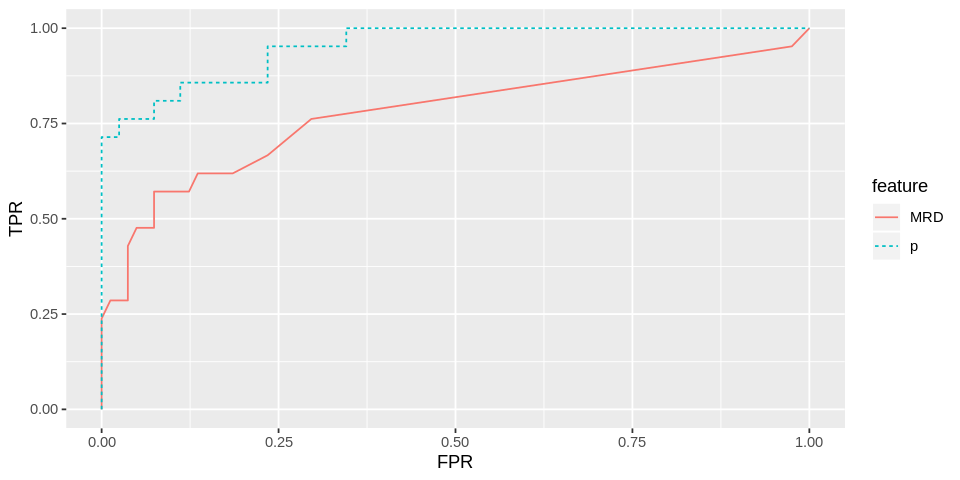

In [70]:
fltr_mrd <- yeoh_label[rownames(p_y), "d33_mrd"]
ax_roc <- plot_proc(p_y$label,
                    data.frame(p_y$p_rel, fltr_mrd),
                    c("p", "MRD"), c(T, T))
ax_roc
# ggsave("~/Dropbox/temp/roc-p_rel.pdf", ax_roc,
#        height = 6, width = 6.5)

### Train/test split

#### Remove samples from certain subtypes from evaluation

In [ ]:
## Collate feature values into matrix

## Calculate mu and sigma from training set for each feature

## Save mu and sigma

Setting levels: control = Good, case = Poor
Setting levels: control = Good, case = Poor


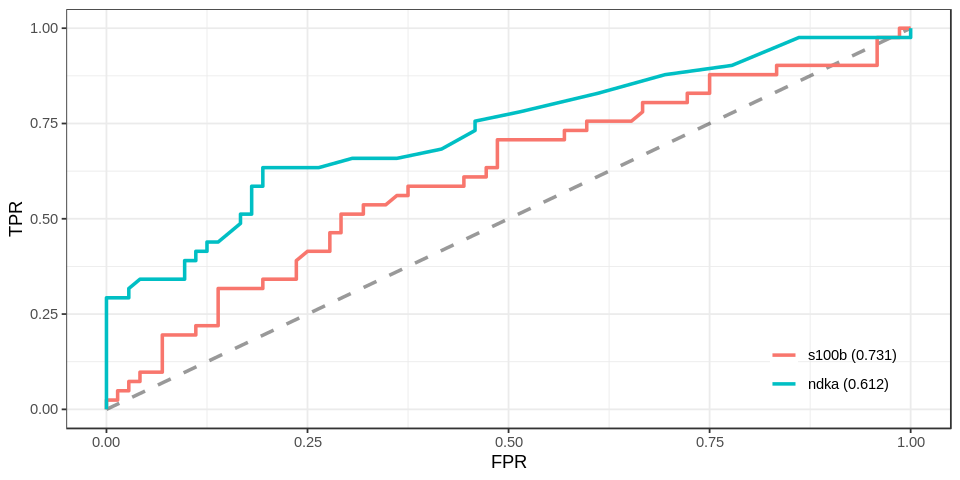

In [220]:
#' @param y vector of labels
#' @param list_x list of vectors containing prediction scores
#' @param bigger.positive logical vector indicating if bigger
#' values have positive labels (e.g. relapse)
plot_roc <- function(y, list_x, x_names, bigger.positive,
                      lwd = 1) {
  n <- length(list_x)
  directions <- ifelse(bigger.positive, "<", ">") # TRUE: controls "<" cases
  
  roc_obj <- roc(y, list_x[[1]],
                 direction = directions[1],
                 ret = "coords")
  roc_df <- data.frame(
    FPR = 1 - roc_obj$specificities,
    TPR = roc_obj$sensitivities
  )
  auc <- roc_obj$auc
  n_row <- nrow(roc_df)
  roc_ord <- roc_df[seq(n_row, 1), ] # reverse order of df
  
  gen_addon <- function(i) {
    roc_obj <- roc(y, list_x[[i]], 
                   direction = directions[i],
                   ret = "coords")
    roc_df <- data.frame(
      FPR = 1 - roc_obj$specificities,
      TPR = roc_obj$sensitivities
    )
    
    return(list(coordinates = roc_df[seq(nrow(roc_df), 1), ],
                auc = roc_obj$auc))
  }
  
  list_obj <- lapply(seq(2, n), gen_addon)
  roc_ords <- lapply(list_obj, function(obj) obj$coordinates)
  aucs <- sapply(list_obj, function(obj) obj$auc)
  n_rows <- sapply(roc_ords, nrow)

  ## Combine first plot with other plots
  all_df <- rbind(roc_ord, do.call(rbind, roc_ords)) # Each row is (FPR, TPR)
  aucs <- c(auc, aucs)
  # No. of points in ROC plot differs due to tied values
  n_rows <- c(n_row, n_rows)
  lnames <- rep(x_names, n_rows)
  plot_df <- cbind(lnames, all_df)
  labels <- sprintf("%s (%.3f)", x_names, aucs)

  ax_roc <- ggplot() +
    geom_segment(aes(x = 0, y = 0, xend = 1, yend = 1),
                 inherit.aes = FALSE,
                 lty = "dashed", lwd = lwd,
                 colour = "black", alpha = .4) +
    geom_line(data = plot_df,
              aes(x = FPR, y = TPR, col = lnames),
              lwd = lwd) +
    scale_color_discrete(name = element_blank(),
                         labels = labels) +
    theme_bw() +
    theme(legend.position = c(.95, .05),
          legend.justification = c("right", "bottom"),
          legend.background = element_rect(fill = NA)) +
    labs(x = "FPR", y = "TPR")

  return(ax_roc)
}

x_names <- c("s100b", "ndka")
ax_roc <- plot_proc(aSAH$outcome, aSAH[,x_names], x_names, c(T, T))
ax_roc
# WPATH <- "~/Dropbox/temp/roc-test.pdf"
# ggsave(WPATH, ax_roc, width = 4.3, height = 4)

In [111]:
## Identify all samples under evaluation
subtypes <- setdiff(levels(Y$subtype),
                    c("Hypodiploid", "Normal", "Others"))
lidx_eval <- Y$subtype %in% subtypes
print(subtypes)
print(sum(lidx_eval))

[1] "BCR-ABL"      "E2A-PBX1"     "Hyperdiploid" "MLL"          "T-ALL"       
[6] "TEL-AML1"    
[1] 230


#### Split by batches (Train: B1-5)

In [102]:
## Define train/test split
## Transfer a few relapse patients from test to train set
## to make sure there are sufficient numbers to model p(x|s, y)
pid_transfer <- c("P102", "P115", "P122", "P167")
pid_transfer1 <- paste0(pid_transfer, rep(c("_D0", "_D8"),
                                          each = length(pid_transfer)))
lidx <- Y$batch_info %in% 1:5 | rownames(Y) %in% pid_transfer1
idx_train <- rownames(Y)[lidx_eval & lidx]
idx_test <- rownames(Y)[lidx_eval & !lidx]
Y_train <- Y[idx_train,]
Y_test <- Y[idx_test,]

tab_train <- table(Y_train$subtype, Y_train$label)
tab_test <- table(Y_test$subtype, Y_test$label)
print(tab_train)
print(tab_test)

print(nrow(Y_train))
print(nrow(Y_test))

              
                0  1
  BCR-ABL       6  4
  E2A-PBX1      6  2
  Hyperdiploid 22  4
  Hypodiploid   0  0
  MLL           2  4
  Normal        0  0
  Others        0  0
  T-ALL        18  2
  TEL-AML1     40 10
              
                0  1
  BCR-ABL       4  6
  E2A-PBX1      4  2
  Hyperdiploid 44  6
  Hypodiploid   0  0
  MLL           4  6
  Normal        0  0
  Others        0  0
  T-ALL         4  2
  TEL-AML1     26  2
[1] 120
[1] 110


### Compute prediction features

In [109]:
#' Predict each subtype with train/test split
#' @param subtype string indicating subtype
# Non-locals: pid_remission, Y, X
predict_train_test1 <- function(subtype,
                               X, Y,
                               pid_remission,
                               idx_global_train,
                               idx_global_test,
                               batch_genes) {
  idx <- rownames(Y)[Y$subtype == subtype]
  n <- length(idx)
  idx1 <- substring(idx, 1, 4)
  
  # Check that pid provided is paired
  if (!all(idx1[1:(n/2)] == idx1[(n/2 + 1):n]))
    stop("Patient IDs are not paired..")
  
  idx_train <- intersect(idx, idx_global_train)
  idx_test <- intersect(idx, idx_global_test)
  X_train <- X[, idx_train]
  
  ## Feature selection using train set
  class_genes <- getLocalGenes(X_train, pid_remission)
  print("DEBUG")
  print(class(X_train))
  selected_genes <- setdiff(class_genes, batch_genes)
  
  print(c("No. of class genes = ", length(class_genes)))
  print(c("No. of selected genes = ", length(selected_genes)))
  
  # Subtype and normal samples
  idx_norm <- paste0("N0", c(1,2,4))
  X_fltr_subtype_norm <- X[selected_genes, c(idx, idx_norm)]
  
  idx_d0d8 <- 1:(ncol(X_fltr_subtype_norm)-3)
  response <- t(X_fltr_subtype_norm)[idx_d0d8, ]
  normal <- t(X_fltr_subtype_norm)[-idx_d0d8, ]
  
  print(rownames(response))
  print(rownames(normal))

  # Collate MRD results as well
  results <- calcERM(response, normal)
  label <- as.factor(metadata_df[rownames(results), "label"])
  
  return(Y)
}

In [110]:
## Collate final prediction from each subtype
list_all <- lapply(subtypes, predict_train_test1,
                   data, Y, pid_remission,
                   idx_train, idx_test, batch_genes)

[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 766"
[1] "No. of features (p-value) = 132"
[1] "No. of features (log2-fc) = 314"
[1] "DEBUG"
[1] "data.frame"
[1] "No. of class genes = " "14"                   
[1] "No. of selected genes = " "10"                      
 [1] "P053_D0" "P054_D0" "P055_D0" "P056_D0" "P057_D0" "P134_D0" "P152_D0"
 [8] "P170_D0" "P175_D0" "P184_D0" "P053_D8" "P054_D8" "P055_D8" "P056_D8"
[15] "P057_D8" "P134_D8" "P152_D8" "P170_D8" "P175_D8" "P184_D8"
[1] "N01" "N02" "N04"
[1] "No. of NaN values in log-fc = 0"
[1] "No. of probesets excluded by expr threshold = 1105"
[1] "No. of features (p-value) = 356"
[1] "No. of features (log2-fc) = 813"
[1] "DEBUG"
[1] "data.frame"
[1] "No. of class genes = " "123"                  
[1] "No. of selected genes = " "79"                      
 [1] "P049_D0" "P050_D0" "P051_D0" "P102_D0" "P124_D0" "P145_D0" "P161_D0"
 [8] "P049_D8" "P050_D8" "P051_D8" "P102_D8" "P124_D8" "P145_D8" "P16

ERROR: Error in apply(paired_logfc, 1, median): dim(X) must have a positive length


### Overall ROC
- Estimating probability of remission by calculating percentage of samples in training set with a worse score
- Subtype specific model during estimation
- Combine probability predictions into an overall ROC curve

In [105]:
## Global MRD: Remission
## To estimate p(remission|mrd)
idx_eval_rem <- rownames(Y)[lidx_eval & Y$label == 0]
idx_eval_rem1 <- substring(idx_eval_rem, 1, 4)
mrd_rem <- yeoh_label[idx_eval_rem1, "d33_mrd"]
names(mrd_rem) <- idx_eval_rem1

idx_train1 <- substring(idx_train, 1, 4)
mrd_rem_train <- mrd_rem[idx_train1]
mrd_rem_train1 <- mrd_rem_train[!is.na(mrd_rem_train)]

In [ ]:
## Collate final prediction from each subtype
list_all <- lapply(subtypes1, predict_train_test,
                   data, Y, pid_remission, mrd_rem_train1,
                   idx_train, idx_test, batch_genes)

In [146]:
train_p <- do.call(rbind, list_all)
train_p_ord <- train_p[order(rownames(train_p)), , drop = F] # sort rows
all_y <- yeoh_label[rownames(train_p_ord), c("d33_mrd", "label")]
erm_sub <- erm[rownames(train_p_ord), , drop = F]

print(tail(rownames(train_p_ord))) # check that all rows are ordered the same!!!
print(tail(rownames(erm_sub)))
print(tail(rownames(all_y)))

train_p_y <- cbind(erm_sub,
             train_p_ord,
             all_y)
train_p_y_sub <- train_p_y[!is.na(train_p_y$d33_mrd),]
print(train_p_y_sub)

[1] "P190" "P195" "P196" "P207" "P208" "P211"
[1] "P190" "P195" "P196" "P207" "P208" "P211"
[1] "P190" "P195" "P196" "P207" "P208" "P211"
            erm1         p       p_wo d33_mrd label
P001  72.4693088 0.5690236 0.69696970   5e-04     0
P004  26.0110292 0.5743547 0.75757576   8e-02     0
P005  56.1740685 0.8347363 0.78787879   1e-04     0
P008  80.4078328 0.9483726 0.93939394   1e-04     0
P010   5.3284511 0.4938272 0.33333333   1e-04     0
P012  15.2062574 0.3872054 0.45454545   5e-04     0
P013  70.3467926 0.6301908 0.51515152   1e-04     0
P014  40.6700798 0.5771605 0.44444444   1e-04     0
P015  30.2995227 0.2233446 0.25252525   7e-04     0
P016  23.7576810 0.3574635 0.15151515   1e-04     0
P017  62.0457473 0.7968575 0.73737374   1e-04     0
P018   8.0174993 0.2968575 0.07070707   1e-04     0
P022  21.7618791 0.3726150 0.17171717   1e-04     0
P023 -49.0432400 0.1346801 0.08080808   2e-04     0
P024  54.0243328 0.5317059 0.38383838   1e-04     0
P025  60.1526724 0.6074635 0.4

In [132]:
test_p <- do.call(rbind, list_all)
test_p_ord <- test_p[order(rownames(test_p)), , drop = F] # sort rows
all_y <- yeoh_label[rownames(test_p_ord), c("d33_mrd", "label")]
erm_sub <- erm[rownames(test_p_ord), , drop = F]

print(tail(rownames(test_p_ord))) # check that all rows are ordered the same!!!
print(tail(rownames(erm_sub)))
print(tail(rownames(all_y)))

test_p_y <- cbind(erm_sub,
             test_p_ord,
             all_y)
test_p_y_sub <- p_y[!is.na(p_y$d33_mrd),]

[1] "P151" "P152" "P164" "P167" "P184" "P189"
[1] "P151" "P152" "P164" "P167" "P184" "P189"
[1] "P151" "P152" "P164" "P167" "P184" "P189"


In [158]:
all_p_y <- rbind(train_p_y_sub, test_p_y_sub)
all_p_y$d33_mrd <- -log10(all_p_y$d33_mrd) 
long_all_p_y <- melt(all_p_y, id.vars = "label", variable.name = "feature")
print(head(long_all_p_y))

ax_jitter <- ggplot(long_all_p_y, aes(x = feature, y = value, col = as.factor(label))) +
  geom_point(position = position_jitterdodge(), cex = 3, show.legend = F) +
  scale_color_manual(values = c("darkolivegreen3", "tomato3")) +
  facet_wrap(~feature, nrow = 1, scales = "free")

ggsave("~/Dropbox/temp/jitter-trainrem_testrel.pdf",
       ax_jitter, width = 12, height = 6)

  label feature     value
1     0    erm1 72.469309
2     0    erm1 26.011029
3     0    erm1 56.174068
4     0    erm1 80.407833
5     0    erm1  5.328451
6     0    erm1 15.206257


### Yeoh (2018): Global ERM
- Feature selection: Top 500 down-regulated probesets (Wilcoxon signed-rank test)
- Calculation of ERM on subspace (no PCA)

In [439]:
pid_d0 <- paste0(rownames(p_y), "_D0")
pid_d8 <- paste0(rownames(p_y), "_D8")

In [440]:
### Yeoh (2018): Prediction

## Feature selection
D0 <- data[, pid_d0]
D8 <- data[, pid_d8]

if (!all(substr(colnames(D0), 1, 4) == substr(colnames(D8), 1, 4)))
  stop("pids do not match!")

row_wilcox <- function(X, Y) {
  mapply(
    function(x, y) wilcox.test(x, y, paired = T)$p.value,
    data.frame(t(X)),
    data.frame(t(Y))
  )
}

wilcox_pvalue <- row_wilcox(D0, D8)
names(wilcox_pvalue) <- substring(names(wilcox_pvalue), 2)

Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”Warning message in wilcox.test.default(x, y, paired = T):
“cannot compute exact p-value with zeroes”

In [441]:
top_wilcox <- head(sort(wilcox_pvalue), 1000)
ps_wilcox <- names(top_wilcox)

response <- t(data[ps_wilcox, c(pid_d0, pid_d8)])
normal <- t(data[ps_wilcox, 403:405])
results <- calcERM(response, normal)
erm <- results[,"erm1", drop = F]

Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1
Setting levels: control = 0, case = 1


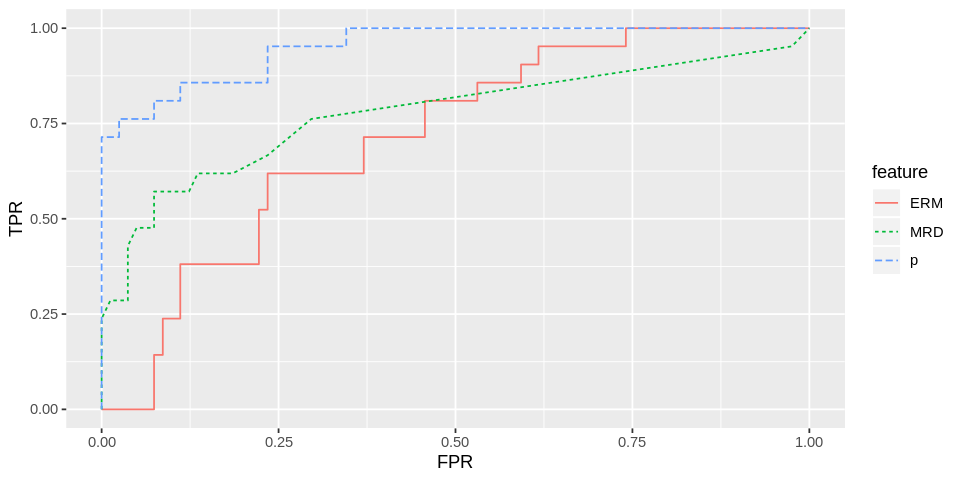

In [443]:
fltr_mrd <- yeoh_label[rownames(p_y), "d33_mrd"]
ax_roc <- plot_proc(p_y$label,
                    data.frame(p_y$p_rel, fltr_mrd, erm),
                    c("p", "MRD", "ERM"),
                    c(T, T, F))
ax_roc
ggsave("~/Dropbox/temp/roc-p_rel.pdf", ax_roc,
       height = 6, width = 6.5)

#### Prediction
- Batch genes: Both train and test set
- Feature selection: Train set
- Calculation of engineered features

In [106]:
#' Predict each subtype with train/test split
#' @param subtype string indicating subtype
# Non-locals: pid_remission, Y, X
predict_train_test <- function(subtype,
                               X, Y,
                               pid_remission,
                               mrd_global,
                               idx_global_train,
                               idx_global_test,
                               batch_genes) {
  idx <- rownames(Y)[Y$subtype == subtype]
  n <- length(idx)
  idx1 <- substring(idx, 1, 4)
  
  # Check that pid provided is paired
  if (!all(idx1[1:(n/2)] == idx1[(n/2 + 1):n]))
    stop("Patient IDs are not paired..")
  
  idx_train <- intersect(idx, idx_global_train)
  idx_test <- intersect(idx, idx_global_test)
  ## NOTE: idx1 (pid) is HALF the length of idx (id)!
  idx1_train <- unique(substring(idx_train, 1, 4))
  idx1_test <- unique(substring(idx_test, 1, 4))
  X_train <- X[, idx_train]
  
  ## Feature selection using train set
  class_genes <- getLocalGenes(X_train, pid_remission)
  selected_genes <- setdiff(class_genes, batch_genes)
  
  print(c("No. of class genes = ", length(class_genes)))
  print(c("No. of selected genes = ", length(selected_genes)))
  
  # Subtype and normal samples
  idx_norm <- paste0("N0", c(1,2,4))
  X_fltr_subtype_norm <- X[selected_genes, c(idx, idx_norm)]
  
  idx_d0d8 <- 1:(ncol(X_fltr_subtype_norm)-3)
  response <- t(X_fltr_subtype_norm)[idx_d0d8, ]
  normal <- t(X_fltr_subtype_norm)[-idx_d0d8, ]
  
  print(rownames(response))
  print(rownames(normal))

  # Collate MRD results as well
  results <- calcERM(response, normal)
  label <- as.factor(metadata_df[rownames(results), "label"])  
  
  Y <- plotPrediction(results, metadata_df, yeoh_label,
                      mrd_global, idx1_train, idx1_test)
  
  return(Y)
}

### Breakdown of train and test sets

In [228]:
nrow(Y_train) + nrow(Y_test)
dim(data)

[1] 201

[1] 5453  405

In [224]:
## Breakdown of train and test sets
idx1 <- Y$batch_info %in% 1:5 & Y$class_info == "D0"
idx2 <- !(Y$batch_info %in% 1:5) & Y$class_info == "D0"
Y_train <- Y[idx1,]
Y_test <- Y[idx2,]

tab_train <- table(Y_train$subtype, Y_train$label)
tab_test <- table(Y_test$subtype, Y_test$label)
print(xtable(tab_train))
print(xtable(tab_test))

% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Fri Jan 22 02:40:53 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & 0 & 1 \\ 
  \hline
BCR-ABL &   3 &   2 \\ 
  E2A-PBX1 &   3 &   0 \\ 
  Hyperdiploid &  11 &   1 \\ 
  Hypodiploid &   0 &   1 \\ 
  MLL &   1 &   0 \\ 
  Normal &   0 &   0 \\ 
  Others &  26 &   6 \\ 
  T-ALL &   9 &   1 \\ 
  TEL-AML1 &  20 &   5 \\ 
   \hline
\end{tabular}
\end{table}
% latex table generated in R 3.5.1 by xtable 1.8-4 package
% Fri Jan 22 02:40:53 2021
\begin{table}[ht]
\centering
\begin{tabular}{rrr}
  \hline
 & 0 & 1 \\ 
  \hline
BCR-ABL &   2 &   3 \\ 
  E2A-PBX1 &   2 &   2 \\ 
  Hyperdiploid &  22 &   4 \\ 
  Hypodiploid &   0 &   0 \\ 
  MLL &   2 &   5 \\ 
  Normal &   0 &   0 \\ 
  Others &  37 &  16 \\ 
  T-ALL &   2 &   1 \\ 
  TEL-AML1 &  13 &   1 \\ 
   \hline
\end{tabular}
\end{table}
